In [ ]:
# Libraries
! python -m pip install --upgrade pip

! pip install pygame
! pip install midiutil

In [1]:
#Imports
import numpy as np
from midi import *
from midiutil import MIDIFile
import matplotlib.pyplot as plt

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html
Playing test.mid

Saving test.wav


In [46]:
# CONSTANTS
L = 16 # length of measure
bpm = 400 # bpm

p1 = 0.8 # Split 2 prob
p2 = 0.1 # Play beat prob
p3 = 0.1 # Play no beat
p4 = 0.8 # Play beat in final level

In [47]:
# Function which chooses a rule according to the probs
def choose_rule(size):
    choice = np.random.random()
    
    # Not last level
    if(size != 1):
        if(choice < p1):
            return 1
        if(choice < p1+p2):
            return 2
        if(choice < p1+p2+p3):
            return 3
    
    #Final level (stop case)
    if(size == 1):
        if(choice < p4):
            return 2
        else:
            return 3

In [48]:
# Rhythm generation
def generate_rhythm(size, volume):
    rhythm = np.zeros(size)
    
    # Recursion
    rule = choose_rule(size)
    
    if (rule == 1):
        rhythm = np.append( generate_rhythm(int(size/2), volume*1) , generate_rhythm(int(size/2), volume*0.98) )    
    if (rule == 2):
        rhythm[0] = volume   
    return rhythm

# Tempo generation
def generate_tempo(size):   
    tempo = np.zeros(size)
    tempo[0:-1:4] = 255    
    return tempo

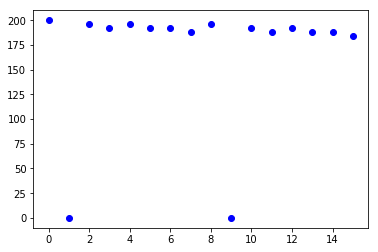

In [49]:
#Generate the audio beat and play it
rhythm = generate_rhythm(L, 200)
plt.plot(rhythm, 'bo')
plt.show()

degree   = 60   # pitch
track    = 0
channel  = 0
time     = 1    # In beats
duration = 1    # In beats
tempo    = bpm  # In BPM
volumes  = rhythm.astype(int).tolist()  # 0-127, as per the MIDI standard
tempos   = generate_tempo(L).astype(int).tolist()

MyMIDI = MIDIFile(1)  # One track, defaults to format 1 (tempo track is created automatically)
MyMIDI.addTempo(track, time, tempo)

# Rhythm
MyMIDI.addProgramChange(tracknum=0, channel=0, time=0, program = 115)
for i, volume in enumerate(volumes):
    MyMIDI.addNote(track=0, channel=0, pitch=50, time=time + i, duration=duration, volume=volume)
    
# Tempo
MyMIDI.addProgramChange(tracknum=0, channel=1, time=0, program = 115)    
for i, tempo in enumerate(tempos):
    MyMIDI.addNote(track=0, channel=1, pitch=90, time=time + i, duration=duration, volume=tempo)

with open("test.mid", "wb") as output_file:
    MyMIDI.writeFile(output_file)

play_music("test.mid")

In [50]:
def WNBD(rhythm):
    meter = 4
    beats = np.nonzero(rhythm)[0]
    length = len(beats)
    
    T = np.zeros(length) # as in the paper
    W = np.zeros(length) # denominator weight for (finishes before meter, after meter...)
    D = np.zeros(length) # as in the paper
    
    T = np.minimum(beats % meter, -beats % meter)        
    
    for i in range(length-1): # length-1 because last beat has no next beat
        W[i] = int(beats[i+1]/4) - int(beats[i]/4) + 1
        if (W[i] > 2):
            W[i] = 1
    W[length-1] = int(len(rhythm)/4) - int(beats[length-1]/4) + 1 # last beat special case
    if (W[length-1] > 2): 
        W[length-1] = 1
    
    D = (W/T)[T !=0] # avoid div/0
    return np.sum(D)

WNBD(rhythm)

C:\Users\Spouep\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


12.0

In [53]:
# Functions for probabilities of notes to be played
def prob_to_be_played(size, level):
    N = int(np.log2(size)+1)
    acc = 0
    for i in range (int(N-level)):
        acc += p1**(i+level) * p2
    
    return p4 * p1**N + acc

vprob_to_be_played = np.vectorize(prob_to_be_played)

def levels(size):
    N = int(np.log2(size)+1)
    levels = np.zeros(size)
    
    for i in range(size):
        for j in range(N):
            if (i%(2**j) != 0):
                levels[i] += 1
                
    return levels
    
def probs_in_measure(size):
    return vprob_to_be_played(size, levels(size))

def probs_in_order(size):
    N = int(np.log2(size)+1)
    probs = np.zeros(N)
    for i in range(N):
        probs[i] = vprob_to_be_played(size, i)
    return probs

<function matplotlib.pyplot.show>

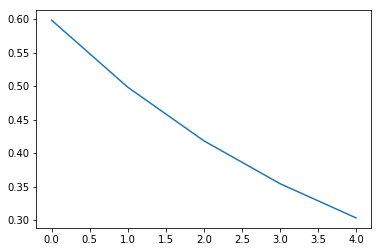

In [54]:
plt.plot(probs_in_order(L))
plt.show